## Libraries

In [1]:
# Libraries
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.linalg import null_space, det
from tentacles import *
import itertools
import os
from tqdm import tqdm # type: ignore
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import copy
from pymoo.core.problem import ElementwiseProblem # type: ignore
from pymoo.algorithms.moo.nsga2 import NSGA2 # type: ignore
from pymoo.optimize import minimize # type: ignore
from pymoo.visualization.scatter import Scatter # type: ignore
from pymoo.termination import get_termination
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting
from pymoo.indicators.hv import HV

In [2]:
# Hyperparameters
DISCRETIZATION = 8
NEW_PERTURB = 50
LIMIT = 0.05

## First dataset creation (for coarse optimization)

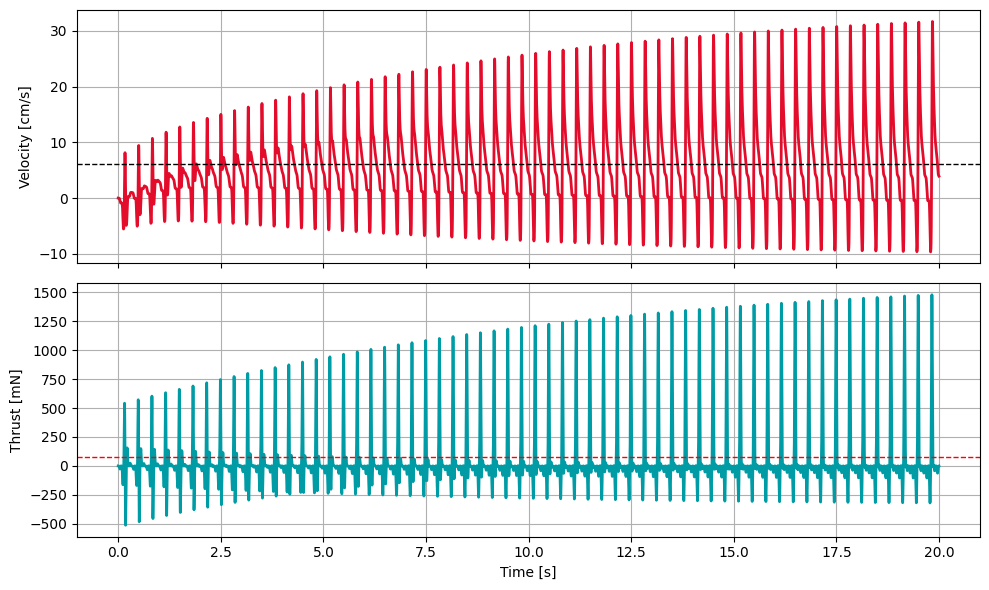

In [3]:
L = 0.5
c = 0.5
f = 3
A = np.deg2rad(45)

if True:
    thrust, velocity = NVE(L, c, f, A, plot=True)

In [4]:
def simulate_and_extend_dataset(points, dataset_path=None):
    """
    Simulates a list of parameter points and optionally appends the results
    to an existing dataset.

    Args:
        points (np.ndarray): array of shape (N, 4) with parameters [L, c, f, A].
        dataset_path (str or None): if provided, loads and extends the dataset at this path,
                                    otherwise creates a new one.

    Returns:
        inputs_tensor (torch.Tensor): tensor of shape (N_total, 4).
        outputs_tensor (torch.Tensor): tensor of shape (N_total, 2).
    """
    inputs = []
    outputs = []

    # Run simulations
    for L, c, f, A in tqdm(points, desc="Simulating NVE points"):
        try:
            thrust, velocity = NVE(L, c, f, A, plot=False)
            inputs.append([L, c, f, A])
            outputs.append([thrust, velocity])
        except Exception:
            continue  # Skip failed simulation

    # Convert to tensors
    inputs_tensor = torch.tensor(inputs, dtype=torch.float32)
    outputs_tensor = torch.tensor(outputs, dtype=torch.float32)

    # Optionally extend existing dataset
    if dataset_path and os.path.exists(dataset_path):
        existing = torch.load(dataset_path, weights_only=True)
        inputs_tensor = torch.cat([existing["inputs"], inputs_tensor], dim=0)
        outputs_tensor = torch.cat([existing["outputs"], outputs_tensor], dim=0)

    # Save updated dataset
    if dataset_path:
        torch.save({"inputs": inputs_tensor, "outputs": outputs_tensor}, dataset_path)
        print(f"\n Updated dataset saved to {dataset_path}")

In [ ]:
# Discretization for initial grid sampling
discretization = DISCRETIZATION

# Define parameter ranges
L_range = np.linspace(0.1, 1, discretization)
c_range = np.linspace(0.0, 1.0, discretization)
f_range = np.linspace(0.05, 10.0, discretization)
A_range_deg = np.linspace(5, 135, discretization)
A_range_rad = np.deg2rad(A_range_deg)

# Generate all parameter combinations
param_grid = np.array(list(itertools.product(L_range, c_range, f_range, A_range_rad)))

# Run simulations and save dataset
if True:
    simulate_and_extend_dataset(
        points=param_grid,
        dataset_path="nve_dataset.pt"
    )

Simulating NVE points:  39%|███▊      | 1577/4096 [9:48:58<12:19:55, 17.62s/it]

In [ ]:
class NVEModel_norm(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(4, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )

    def forward(self, x):
        return self.net(x)

class NVEModel(nn.Module):
    def __init__(self, model, y_min, y_max):
        super().__init__()
        self.model = model
        self.y_min = nn.Parameter(y_min, requires_grad=False)
        self.y_max = nn.Parameter(y_max, requires_grad=False)

    def forward(self, x):
        y_norm = self.model(x)
        return y_norm * (self.y_max - self.y_min) + self.y_min

In [ ]:
def train_nve_model_from_dataset(dataset_path="nve_dataset.pt"):
    """
    Trains a neural network on the normalized NVE dataset.
    Saves the final model if requested. Returns it only if not saving.

    Args:
        dataset_path (str): path to the .pt file containing {"inputs": X, "outputs": y}.
        save_model (bool): if True, saves the trained model to disk and returns nothing.

    Returns:
        model_with_denorm (nn.Module)
    """
    # Load dataset
    data = torch.load(dataset_path, weights_only=True)
    X = data["inputs"]
    y_raw = data["outputs"]

    # Normalize outputs
    y_min = y_raw.min(dim=0).values
    y_max = y_raw.max(dim=0).values
    y_norm = (y_raw - y_min) / (y_max - y_min)

    # Split into training and validation sets
    num_samples = X.shape[0]
    split_idx = int(0.9 * num_samples)
    X_train, X_val = X[:split_idx], X[split_idx:]
    y_train, y_val = y_norm[:split_idx], y_norm[split_idx:]

    # Create DataLoaders
    dataset_train = TensorDataset(X_train, y_train)
    dataset_val = TensorDataset(X_val, y_val)
    loader_train = DataLoader(dataset_train, batch_size=64, shuffle=True)
    loader_val = DataLoader(dataset_val, batch_size=64, shuffle=False)

    model = NVEModel_norm()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    # Training loop with early stopping
    epochs = 300
    patience = 20
    best_val_loss = float('inf')
    best_model = None
    wait = 0
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        loss_epoch = 0
        for xb, yb in loader_train:
            pred = model(xb)
            loss = criterion(pred, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_epoch += loss.item() * xb.size(0)
        train_losses.append(loss_epoch / len(loader_train.dataset))

        model.eval()
        with torch.no_grad():
            val_loss = 0
            for xb, yb in loader_val:
                pred = model(xb)
                val_loss += criterion(pred, yb).item() * xb.size(0)
        val_loss /= len(loader_val.dataset)
        val_losses.append(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = copy.deepcopy(model.state_dict())
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print(f"Early stopping at epoch {epoch}")
                break

        if epoch % 10 == 0:
            print(f"Epoch {epoch:3d} | Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f}")

    # Load best model weights
    model.load_state_dict(best_model)

    model_with_denorm = NVEModel(model, y_min, y_max)

    # Plot losses
    plt.figure()
    plt.plot(train_losses, label='Train')
    plt.plot(val_losses, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss (normalized)')
    plt.legend()
    plt.grid(True)
    plt.title("Training and Validation Loss")
    plt.show()

    # Save or return
    torch.save(model_with_denorm, "nve_model.pt")
    print("Entire model saved to nve_model.pt")

    return model_with_denorm

In [ ]:
# Define the multi-objective problem
class NVEOptimizationProblem(ElementwiseProblem):
    def __init__(self, model):
        super().__init__(n_var=4, n_obj=2, n_constr=0,
                         xl=np.array([0.1, 0.0, 0.05, np.deg2rad(5)]),
                         xu=np.array([1, 1.0, 10.0, np.deg2rad(135)]))
        self.model = model

    def _evaluate(self, x, out, *args, **kwargs):
        x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(0)
        with torch.no_grad():
            pred = self.model(x_tensor).squeeze(0).numpy()

        # Objectives: we want to maximize both → negate them for minimization
        out["F"] = - pred  # [thrust, velocity]

## Active learning for model refinement

In [ ]:
def sample_around_pareto(pareto_points, N_new, sigma, bounds, max_attempts=50):
    """
    Sample points around Pareto front with Gaussian noise, ensuring all samples stay within bounds.
    If sampling fails after `max_attempts`, the original point is used.
    """
    lower, upper = np.array(bounds[0]), np.array(bounds[1])
    M = len(pareto_points)
    n_per_point = max(1, N_new // M)
    samples = []

    for x in pareto_points:
        count = 0
        while count < n_per_point:
            for attempt in range(max_attempts):
                noise = np.random.normal(0, sigma, size=(1, 4))
                perturbed = x + noise
                if np.all(perturbed >= lower) and np.all(perturbed <= upper):
                    samples.append(perturbed[0])
                    break
            else:
                # After max_attempts, use the original point
                samples.append(x)
            count = count + 1

    return np.array(samples)[:N_new]

In [ ]:
def iterative_pareto_refinement(max_iter=200, N_new=NEW_PERTURB, sigma=0.10, dataset_path="nve_dataset.pt", pop_size=100, delta_threshold=LIMIT):
    bounds = (
        np.array([0.1, 0.0, 0.05, np.deg2rad(5)]),  # lower
        np.array([1, 1.0, 10.0, np.deg2rad(135)])  # upper
    )


    hv = HV(ref_point=np.array([0.0, 0.0]))  # reference
    prev_hv = None
    delta_hv_history = []

    final_pareto_X = None
    final_pareto_F = None

    for i in range(max_iter):
        print(f"\n=== Iteration {i+1} ===")

        # Train model on current dataset
        model = train_nve_model_from_dataset(dataset_path)

        # Optimize current model with NSGA-II
        problem = NVEOptimizationProblem(model)
        algorithm = NSGA2(pop_size=pop_size)
        res = minimize(problem,
                       algorithm,
                       termination=get_termination("moo"),
                       seed=1,
                       save_history=False,
                       verbose=True)

        # Extract Pareto front
        pareto_X = res.X
        pareto_F = -res.F  # un-negate to get actual thrust and velocity

        # Compute hypervolume
        hv_now = hv(res.F)
        print(f"Hypervolume: {hv_now}")
        if prev_hv is not None:
            delta_hv = np.abs(hv_now - prev_hv)
            delta_hv_history.append(delta_hv)
            print(f"Hypervolume delta: {delta_hv:.6f}")

            # Check plateau over last 5 iterations
            if len(delta_hv_history) >= 5:
                recent_max = np.max(delta_hv_history[-5:])
                print(f"Recent max delta HV: {recent_max:.6f}")
                if recent_max < delta_threshold:
                    print("Plateau detected — stopping iterations.")
                    break
        prev_hv = hv_now

        # Plot current Pareto front
        plt.figure(figsize=(6, 5))
        plt.scatter(
        pareto_F[:, 0] * 1000,
        pareto_F[:, 1] * 100,
        s=50,
        facecolors='none',
        edgecolors='#e2001a',
        linewidths=1.5,
        alpha=0.8
        )
        plt.xlabel("Thrust [mN]", fontsize=12)
        plt.ylabel("Velocity [cm/s]", fontsize=12)
        plt.title(f"Pareto Front - Iteration {i+1}", fontsize=13)
        plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
        plt.tight_layout()
        plt.show()

        # Store final Pareto front
        final_pareto_X = pareto_X
        final_pareto_F = pareto_F

        # Sample new points around Pareto front
        new_points = sample_around_pareto(pareto_X, N_new=N_new, sigma=sigma, bounds=bounds)

        # Simulate and update dataset
        simulate_and_extend_dataset(new_points, dataset_path=dataset_path)

    
    # Plot delta HV history
    plt.figure()
    plt.plot(range(1, len(delta_hv_history) + 1), delta_hv_history, marker='o')
    plt.xlabel("Iteration")
    plt.ylabel("Delta Hypervolume")
    plt.title("Hypervolume Delta Across Iterations")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Return final Pareto front
    return final_pareto_X, final_pareto_F

In [ ]:
# Application of Pareto front
X_pareto, F_pareto = iterative_pareto_refinement(
    sigma=np.array([0.2, 0.2, 0.4, np.deg2rad(10)])
)
# Save final Pareto front
np.savez("pareto_results.npz", X=X_pareto, F=F_pareto)
print("Saved final Pareto front to pareto_results.npz")

## Statistical analysis of Pareto front

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

def analyze_pareto_front(F_pareto, X_pareto):
    # Compute derived quantities
    thrusts = F_pareto[:, 0]
    velocities = F_pareto[:, 1]
    powers = thrusts * velocities

    # Maximum indices
    idx_thrust = thrusts.argmax()
    idx_velocity = velocities.argmax()
    idx_power = powers.argmax()

    print("=== Best by THRUST ===")
    L, c, f, A = X_pareto[idx_thrust]
    print(f"L={L:.3f} m, c={c:.3f}, f={f:.3f} Hz, A={np.rad2deg(A):.1f}° → Thrust={thrusts[idx_thrust]:.4f} N, Velocity={velocities[idx_thrust]:.4f} m/s")

    print("\n=== Best by VELOCITY ===")
    L, c, f, A = X_pareto[idx_velocity]
    print(f"L={L:.3f} m, c={c:.3f}, f={f:.3f} Hz, A={np.rad2deg(A):.1f}° → Thrust={thrusts[idx_velocity]:.4f} N, Velocity={velocities[idx_velocity]:.4f} m/s")

    print("\n=== Best by POWER (Thrust·Velocity) ===")
    L, c, f, A = X_pareto[idx_power]
    print(f"L={L:.3f} m, c={c:.3f}, f={f:.3f} Hz, A={np.rad2deg(A):.1f}° → Thrust={thrusts[idx_power]:.4f} N, Velocity={velocities[idx_power]:.4f} m/s, Power={powers[idx_power]:.4f} W")

    # Summary statistics with units
    units = ["N", "m/s", "W"]
    for name, arr, unit in zip(["Thrust", "Velocity", "Power"], [thrusts, velocities, powers], units):
        print(f"\n{name} stats: min={arr.min():.4f} {unit}, max={arr.max():.4f} {unit}, "
              f"mean={arr.mean():.4f} {unit}, std={arr.std():.4f} {unit}, median={np.median(arr):.4f} {unit}")

    # Boxplots
    colors = ["#6baed6", "#74c476", "#fd8d3c"]
    for data, name, color in zip([thrusts, velocities, powers], ["Thrust [N]", "Velocity [m/s]", "Power [W]"], colors):
        plt.figure(figsize=(6, 5))
        sns.boxplot(y=data, color=color)
        plt.ylabel(name, fontsize=12)
        plt.title(f"Distribution of {name}", fontsize=14)
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()

    # Histograms
    for data, name, color in zip([thrusts, velocities, powers], ["Thrust [N]", "Velocity [m/s]", "Power [W]"], colors):
        plt.figure(figsize=(6, 4))
        plt.hist(data, bins=20, color=color, edgecolor='black', alpha=0.8)
        plt.xlabel(name)
        plt.ylabel("Frequency")
        plt.title(f"Histogram of {name}")
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()

    # Scatter with color-coded power
    plt.figure(figsize=(8, 6))
    sc = plt.scatter(thrusts, velocities, c=powers, cmap="viridis", edgecolors='k', s=60)
    plt.xlabel("Thrust [N]", fontsize=12)
    plt.ylabel("Velocity [m/s]", fontsize=12)
    plt.title("Pareto Front with Power Levels", fontsize=14)
    cbar = plt.colorbar(sc)
    cbar.set_label("Power [W]", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

    # Parametric plots: Thrust and Velocity vs each input
    param_names = ["L [m]", "c", "f [Hz]", "A [deg]"]
    param_data = [X_pareto[:, 0], X_pareto[:, 1], X_pareto[:, 2], np.rad2deg(X_pareto[:, 3])]

    for name, values in zip(param_names, param_data):
        fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharex=True)
        axs[0].scatter(values, thrusts, color="#1f77b4", edgecolors='k', s=40)
        axs[0].set_ylabel("Thrust [N]")
        axs[0].set_xlabel(name)
        axs[0].grid(True, linestyle='--', alpha=0.6)

        axs[1].scatter(values, velocities, color="#ff7f0e", edgecolors='k', s=40)
        axs[1].set_ylabel("Velocity [m/s]")
        axs[1].set_xlabel(name)
        axs[1].grid(True, linestyle='--', alpha=0.6)

        fig.suptitle(f"Effect of {name} on Thrust and Velocity", fontsize=14)
        plt.tight_layout()
        plt.show()

In [ ]:
data = np.load("pareto_results.npz")
X_pareto = data["X"]
F_pareto = data["F"]

analyze_pareto_front(F_pareto, X_pareto)